In [1]:
import ROOT 
import os, sys

Welcome to JupyROOT 6.24/02


In [2]:
ROOT.gInterpreter.Declare("""
auto MuTypeVector(ROOT::RVec<int>& muType, int num){
    ROOT::RVec<int> vec;
    vec.clear();
    const auto size = muType.size();
    for (auto i = 0; i < size; ++i) {
        if ((muType[i] >> num & 1) == 1) 
            vec.push_back(1);
        else 
            vec.push_back(0);
    }
    return vec;
}
""")

ROOT.gInterpreter.Declare("""
auto NoneZeroIso03(ROOT::RVec<float>& muPFChIso03, ROOT::RVec<float>& muPFNeuIso03, ROOT::RVec<float>& muPFPhoIso03, ROOT::RVec<float>& muPFPUIso03){
    ROOT::RVec<float> vec;
    vec.clear();
    const auto size = muPFChIso03.size();
    for (auto i = 0; i < size; ++i) {
            vec.push_back(muPFChIso03[i] + TMath::Max(0., muPFNeuIso03[i] + muPFPhoIso03[i] - 0.5*muPFPUIso03[i]));
    }
    return vec;
}
""")

ROOT.gInterpreter.Declare("""
using VecF_t = const ROOT::RVec<float>&;
using VecI_t = const ROOT::RVec<int>&;
auto HggPreSelection(float rhoAll, int nEle, VecF_t eleSCEta, int nPho, VecF_t phoSCEta, VecF_t phoPFChIso, VecF_t phoPFPhoIso, VecF_t phoTrkIsoHollowConeDR03, VecF_t phoR9Full5x5, VecF_t phoCalibEt, VecF_t phoSigmaIEtaIEtaFull5x5, VecF_t phoHoverE){

    ROOT::RVec<int> vec;
    vec.clear();
    for (int ele_ind = 0; ele_ind < nEle; ele_ind++){
        
        int isHgg = 0;
        int pho_ind = -1;
        int ele_passInd = 999;
        for (int i = 0; i < nPho; i++){
            if (fabs(phoSCEta[i] - eleSCEta[ele_ind]) < 0.0001){
                pho_ind = i;
                break;
            }
        }
        
        if (pho_ind != -1){
            float corr = 0; 
            if (phoSCEta[pho_ind] > 0. && phoSCEta[pho_ind] <= 1.5) corr = 0.16544;
            else if (phoSCEta[pho_ind] > 1.5 && phoSCEta[pho_ind] <= 3.) corr = 0.13212;

            float phoPFChIso_corr = phoPFChIso[pho_ind] - rhoAll * corr;
            float phoPFPhoIso_corr = phoPFPhoIso[pho_ind] - rhoAll * corr;
            float phoTrkIsoHollowConeDR03_corr = phoTrkIsoHollowConeDR03[pho_ind] - rhoAll * corr;

            bool isEB = (fabs(phoSCEta[pho_ind]) < 1.4442);
            bool isEE = (fabs(phoSCEta[pho_ind]) > 1.566 && fabs(phoSCEta[pho_ind]) < 2.5);

            bool isAOD = (phoR9Full5x5[pho_ind] > 0.8 && phoPFChIso_corr < 20.) || (phoPFChIso_corr/phoCalibEt[pho_ind] < 0.3);

            // region
            bool isHR9_EB = phoR9Full5x5[pho_ind] > 0.85 && isEB;
            bool isLR9_EB = phoR9Full5x5[pho_ind] <= 0.85 && phoR9Full5x5[pho_ind] >= 0.5 && isEB;
            bool isHR9_EE = phoR9Full5x5[pho_ind] > 0.9 && isEE;
            bool isLR9_EE = phoR9Full5x5[pho_ind] <= 0.9 && phoR9Full5x5[pho_ind] >= 0.8 && isEE;


            if (isAOD){
                if (isLR9_EB){
                    if (phoHoverE[pho_ind] < 0.08 && phoSigmaIEtaIEtaFull5x5[pho_ind] < 0.015 && phoPFPhoIso_corr < 4. && phoTrkIsoHollowConeDR03_corr < 6.){
                        isHgg = 1;
                    }
                }
                if (isHR9_EB){
                    if (phoHoverE[pho_ind] < 0.08) isHgg = 1;
                }
                if (isLR9_EE){
                    if (phoHoverE[pho_ind] < 0.08 && phoSigmaIEtaIEtaFull5x5[pho_ind] < 0.035 && phoPFPhoIso_corr < 4. && phoTrkIsoHollowConeDR03_corr < 6.){
                        isHgg = 1;
                    }
                }
                if (isHR9_EE){
                    if (phoHoverE[pho_ind] < 0.08) isHgg = 1;
                }
            }
        }
        
        vec.push_back(isHgg);
    }
    
    return vec;
}
""")

True

In [3]:
# ncpus = os.cpu_count() - 2
# ROOT.EnableImplicitMT(ncpus)
f = [
    "/data4/chenghan/mc/V10_02_10_07/job_fall17_ZZ/skim.root",
    "/data4/chenghan/mc/V10_02_10_07/job_autumn18_ZZ/skim.root",
    "/data4/chenghan/mc/V10_02_10_07/job_summer16_ZZ//skim.root"
] 
df = ROOT.RDataFrame("ggNtuplizer/EventTree", f)

In [4]:
# muon types are defined here: CMSSW/DataFormats/MuonReco/interface/Muon.h
# namely: GlobalMuon     = 1<<1
#         TrackerMuon    = 1<<2
#         StandAloneMuon = 1<<3
#         CaloMuon       = 1<<4
#         PFMuon         = 1<<5
#         RPCMuon        = 1<<6

print(df.GetColumnType("muType"))

df = df.Define("isGlobalMuon", "MuTypeVector(muType, 1)")
df = df.Define("isTrackerMuon", "MuTypeVector(muType, 2)")
df = df.Define("isPFMuon", "MuTypeVector(muType, 5)")
df = df.Define("isTrkHighPtMuon", "isTrackerMuon && muStations > 1 && muPixelHits > 0 && muTrkLayers > 5 && abs(muD0) < 0.2 && abs(muDz) < 0.5 && (muBestTrkPtError / muBestTrkPt < 0.3)")

# muon selection
df = df.Define("isHZZLooseMuon", "muPt < 200 && muSIP < 4 && abs(muD0) < 0.5 && abs(muDz) < 1 && muBestTrkType != 2 && (isGlobalMuon ||(isTrackerMuon && muStations > 0))")
df = df.Define("isHZZTightMuon", "muPt >= 200 && isHZZLooseMuon && (isPFMuon || isTrkHighPtMuon)")
df = df.Define("muIso03", "NoneZeroIso03(muPFChIso03, muPFNeuIso03, muPFPhoIso03, muPFPUIso03)")
df = df.Define("isHZZIsoMuon", "(muIso03/muPt) < 0.35")
df = df.Define("isGoodMuon", "muPt > 4 && abs(muEta) < 2.4 && (isHZZLooseMuon || isHZZTightMuon) && isHZZIsoMuon")

df = df.Filter("Sum(isGoodMuon) > 1", "HZZID selection")
df = df.Filter("muPt[isGoodMuon][0] > 20 && muPt[isGoodMuon][1] > 10", "HLT threshold")
df = df.Filter("(muCharge[isGoodMuon][0] * muCharge[isGoodMuon][1]) < 0", "Opposite charge")

df = df.Define("mu1", "TLorentzVector v; v.SetPtEtaPhiM(muPt[isGoodMuon][0], muEta[isGoodMuon][0], muPhi[isGoodMuon][0], 105.658*0.001); return v;")
df = df.Define("mu2", "TLorentzVector v; v.SetPtEtaPhiM(muPt[isGoodMuon][1], muEta[isGoodMuon][1], muPhi[isGoodMuon][1], 105.658*0.001); return v;")
df = df.Define("Zmumu", "mu1 + mu2")
df = df.Define("ZmumuMass", "Zmumu.M()")
df = df.Define("ZmumuPt", "Zmumu.Pt()")
df = df.Define("dR_mumu", "mu1.DeltaR(mu2)")

# df = df.Filter("dR_mumu < 0.4", "boost z")

df.Display({"rdfentry_", "isGoodMuon", "ZmumuMass"}).Print()
df.Report().Print()

ROOT::VecOps::RVec<int>
rdfentry_ | isGoodMuon | ZmumuMass | 
0         | 1          | 90.071599 | 
          | 1          |           | 
2         | 1          | 83.092092 | 
          | 1          |           | 
4         | 1          | 94.073495 | 
          | ...        |           | 
          | 1          |           | 
5         | 1          | 92.445828 | 
          | 1          |           | 
6         | 1          | 94.353480 | 
          | ...        |           | 
          | 0          |           | 
HZZID selection: pass=80051      all=94398      -- eff=84.80 % cumulative eff=84.80 %
HLT threshold: pass=77905      all=80051      -- eff=97.32 % cumulative eff=82.53 %
Opposite charge: pass=77063      all=77905      -- eff=98.92 % cumulative eff=81.64 %


2571.2844483187246
 OBJ: TStatistic	  	 Mean = 88.686 +- 0.08395 	 RMS = 22.838 	 Count = 77063 	 Min = 0.36093 	 Max = 562.92
 OBJ: TStatistic	  	 Mean = 64.258 +- 0.1676 	 RMS = 45.603 	 Count = 77063 	 Min = 0.19989 	 Max = 381.7


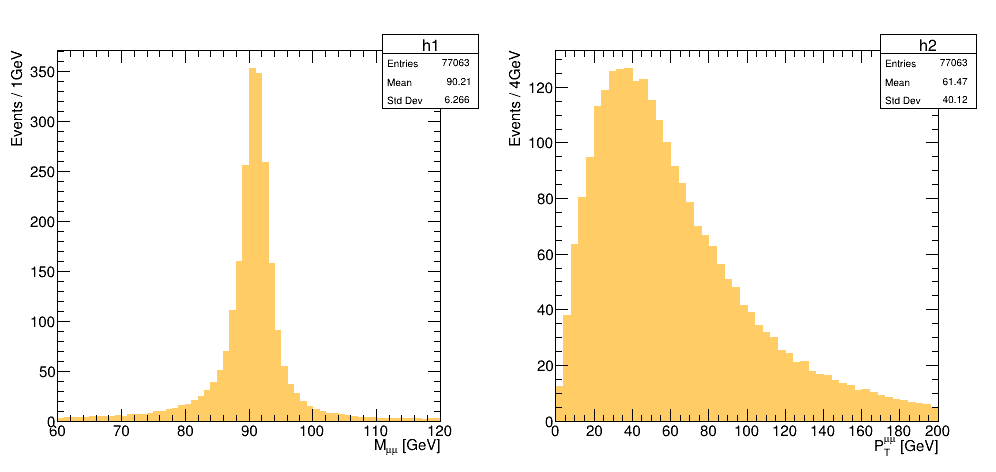

In [5]:
print(df.Stats("ZmumuMass", "wei").GetW())

ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)

c1 = ROOT.TCanvas("c1", "", 1000, 500)
c1.Divide(2)

c1.cd(1)
df.Stats("ZmumuMass", "mcwei").Print()
h1 = df.Histo1D(("h1", " ", 60, 60, 120), "ZmumuMass", "wei")
h1.GetXaxis().SetTitle("M_{#mu#mu} [GeV]")
h1.GetYaxis().SetTitle("Events / 1GeV")
h1.SetFillColor(ROOT.TColor.GetColor(248, 206, 104))
h1.SetLineColor(ROOT.TColor.GetColor(248, 206, 104))
h1.Draw("hist")

c1.cd(2)
df.Stats("ZmumuPt", "mcwei").Print()
h2 = df.Histo1D(("h2", " ", 50, 0, 200), "ZmumuPt", "wei")
h2.GetXaxis().SetTitle("P_{T}^{#mu#mu} [GeV]")
h2.GetYaxis().SetTitle("Events / 4GeV")
h2.SetFillColor(ROOT.TColor.GetColor(248, 206, 104))
h2.SetLineColor(ROOT.TColor.GetColor(248, 206, 104))
h2.Draw("hist")

c1.Draw()

 OBJ: TStatistic	  	 Mean = 2.3727 +- 0.002763 	 RMS = 0.70913 	 Count = 77063 	 Min = 0.0047279 	 Max = 5.0117


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


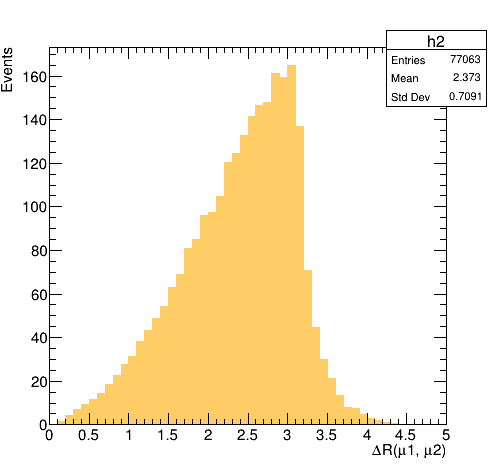

In [6]:
c1 = ROOT.TCanvas("c1", "", 500, 500)
df.Stats("dR_mumu", "wei").Print()
h2 = df.Histo1D(("h2", " ", 50, 0, 5), "dR_mumu", "wei")
h2.GetXaxis().SetTitle("#DeltaR(#mu1, #mu2)")
h2.GetYaxis().SetTitle("Events")
h2.SetFillColor(ROOT.TColor.GetColor(248, 206, 104))
h2.SetLineColor(ROOT.TColor.GetColor(248, 206, 104))
h2.Draw("hist")
c1.Draw()

In [7]:
df1 = df.Define("isM1Ele", "eleClass == 1")
# electron selection

df1 = df1.Define("isHggElectron", "HggPreSelection(rhoAll, nEle, eleSCEta, nPho, phoSCEta, phoPFChIso, phoPFPhoIso, phoTrkIsoHollowConeDR03, phoR9Full5x5, phoCalibEt, phoSigmaIEtaIEtaFull5x5, phoHoverE)")
df1 = df1.Define("isGoodEle_EB", "isHggElectron && isM1Ele && eleCalibPt > 7. && abs(eleSCEta) < 1.4442 && eleEcalDrivenSeed == 1")
df1 = df1.Define("isGoodEle_EE", "isHggElectron && isM1Ele && eleCalibPt > 7. && abs(eleSCEta) > 1.566 && abs(eleSCEta) < 2.5 && eleEcalDrivenSeed == 1")
df1 = df1.Define("isGoodEle", "isGoodEle_EB || isGoodEle_EE")
df1 = df1.Filter("Sum(isGoodEle) > 0", "ele selection")

df1 = df1.Define("ele1", "TLorentzVector v; v.SetPtEtaPhiM(eleCalibPt[isGoodEle][0], eleEta[isGoodEle][0], elePhi[isGoodEle][0], 0.511*0.001); return v;")
df1 = df1.Define("ele1Pt", "ele1.Pt()")
df1 = df1.Define("ele1mumuPt", "ele1Pt/ZmumuPt")
df1 = df1.Define("dR_ele1mu1", "ele1.DeltaR(mu1)")
df1 = df1.Define("dR_ele1mu2", "ele1.DeltaR(mu2)")

df1.Display({"eleCalibPt","isGoodEle", "isHggElectron", "rdfentry_"}).Print()
df1.Report().Print()

rdfentry_ | isHggElectron | eleCalibPt | isGoodEle | 
85        | 1             | 43.1488f   | 1         | 
          | ...           | ...        | ...       | 
          | 0             | 2.29744f   | 0         | 
119       | 1             | 76.8251f   | 0         | 
          | 1             | 29.1032f   | 1         | 
190       | 1             | 52.0575f   | 1         | 
          | 1             | 50.1503f   | 1         | 
199       | 1             | 95.2010f   | 1         | 
          | ...           | ...        | ...       | 
          | 0             | 17.2458f   | 0         | 
211       | 1             | 146.601f   | 1         | 
          | 1             | 25.0199f   | 0         | 
HZZID selection: pass=80051      all=94398      -- eff=84.80 % cumulative eff=84.80 %
HLT threshold: pass=77905      all=80051      -- eff=97.32 % cumulative eff=82.53 %
Opposite charge: pass=77063      all=77905      -- eff=98.92 % cumulative eff=81.64 %
ele selection: pass=1621       all=77063  

56.576378193111836
 OBJ: TStatistic	  	 Mean = 66.94 +- 1.138 	 RMS = 44.884 	 Count = 1621 	 Min = 13.431 	 Max = 367.33
 OBJ: TStatistic	  	 Mean = 1.438 +- 0.1038 	 RMS = 4.0921 	 Count = 1621 	 Min = 0.085362 	 Max = 143.2


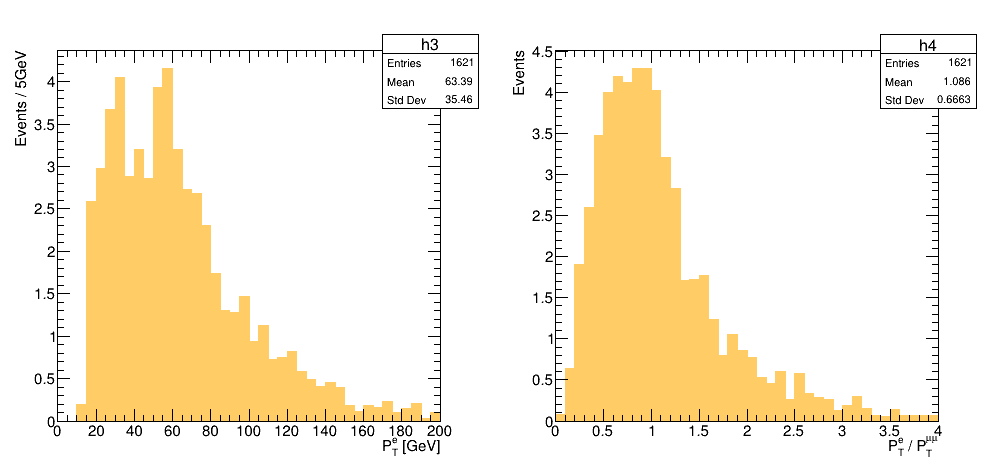

In [8]:
print(df1.Stats("ele1Pt", "wei").GetW())

ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)

c2 = ROOT.TCanvas("c2", "", 1000, 500)
c2.Divide(2)

c2.cd(1)
df1.Stats("ele1Pt", "mcwei").Print()
h3 = df1.Histo1D(("h3", " ", 40, 0, 200), "ele1Pt", "wei")
h3.GetXaxis().SetTitle("P_{T}^{e} [GeV]")
h3.GetYaxis().SetTitle("Events / 5GeV")
h3.SetFillColor(ROOT.TColor.GetColor(248, 206, 104))
h3.SetLineColor(ROOT.TColor.GetColor(248, 206, 104))
h3.Draw("hist")

c2.cd(2)
df1.Stats("ele1mumuPt", "mcwei").Print()
h4 = df1.Histo1D(("h4", " ", 40, 0, 4), "ele1mumuPt", "wei")
h4.GetXaxis().SetTitle("P_{T}^{e} / P_{T}^{#mu#mu}")
h4.GetYaxis().SetTitle("Events")
h4.SetFillColor(ROOT.TColor.GetColor(248, 206, 104))
h4.SetLineColor(ROOT.TColor.GetColor(248, 206, 104))
h4.Draw("hist")

c2.Draw()

 OBJ: TStatistic	  	 Mean = 2.5309 +- 0.02292 	 RMS = 0.86666 	 Count = 1621 	 Min = 0.00015101 	 Max = 5.3798
 OBJ: TStatistic	  	 Mean = 2.139 +- 0.02343 	 RMS = 0.88617 	 Count = 1621 	 Min = 0.0035338 	 Max = 4.8033


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


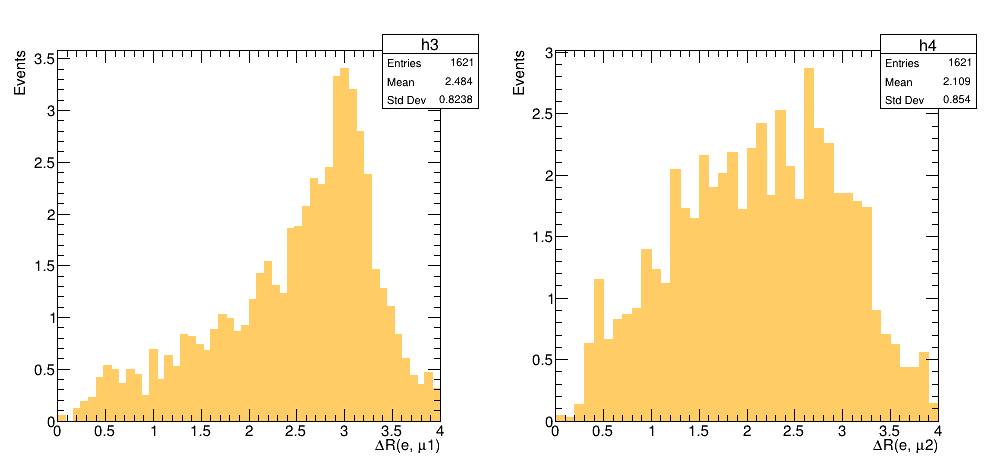

In [9]:
c2 = ROOT.TCanvas("c2", "", 1000, 500)
c2.Divide(2)

c2.cd(1)
df1.Stats("dR_ele1mu1", "wei").Print()
h3 = df1.Histo1D(("h3", " ", 50, 0, 4), "dR_ele1mu1", "wei")
h3.GetXaxis().SetTitle("#DeltaR(e, #mu1)")
h3.GetYaxis().SetTitle("Events")
h3.SetFillColor(ROOT.TColor.GetColor(248, 206, 104))
h3.SetLineColor(ROOT.TColor.GetColor(248, 206, 104))
h3.Draw("hist")

c2.cd(2)
df1.Stats("dR_ele1mu2", "wei").Print()
h4 = df1.Histo1D(("h4", " ", 40, 0, 4), "dR_ele1mu2", "wei")
h4.GetXaxis().SetTitle("#DeltaR(e, #mu2)")
h4.GetYaxis().SetTitle("Events")
h4.SetFillColor(ROOT.TColor.GetColor(248, 206, 104))
h4.SetLineColor(ROOT.TColor.GetColor(248, 206, 104))
h4.Draw("hist")

c2.Draw()

 OBJ: TStatistic	  	 Mean = 88.696 +- 0.08937 	 RMS = 22.941 	 Count = 77063 	 Min = 0.36093 	 Max = 562.92
 OBJ: TStatistic	  	 Mean = 64.337 +- 0.1778 	 RMS = 45.638 	 Count = 77063 	 Min = 0.19989 	 Max = 381.7


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


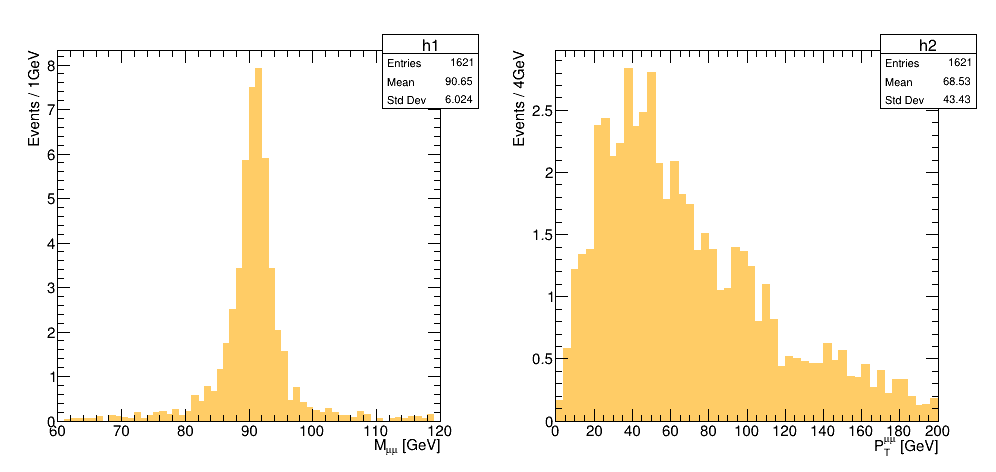

In [10]:
c1 = ROOT.TCanvas("c1", "", 1000, 500)
c1.Divide(2)

c1.cd(1)
df.Stats("ZmumuMass", "wei").Print()
h1 = df1.Histo1D(("h1", " ", 60, 60, 120), "ZmumuMass", "wei")
h1.GetXaxis().SetTitle("M_{#mu#mu} [GeV]")
h1.GetYaxis().SetTitle("Events / 1GeV")
h1.SetFillColor(ROOT.TColor.GetColor(248, 206, 104))
h1.SetLineColor(ROOT.TColor.GetColor(248, 206, 104))
h1.Draw("hist")

c1.cd(2)
df.Stats("ZmumuPt", "wei").Print()
h2 = df1.Histo1D(("h2", " ", 50, 0, 200), "ZmumuPt", "wei")
h2.GetXaxis().SetTitle("P_{T}^{#mu#mu} [GeV]")
h2.GetYaxis().SetTitle("Events / 4GeV")
h2.SetFillColor(ROOT.TColor.GetColor(248, 206, 104))
h2.SetLineColor(ROOT.TColor.GetColor(248, 206, 104))
h2.Draw("hist")

c1.Draw()

In [11]:
%%cpp -d 
int GenMatchInd(TLorentzVector reco, int nMC, ROOT::RVec<float>& mcPt, ROOT::RVec<float>& mcEta, ROOT::RVec<float>& mcPhi, ROOT::RVec<float>& mcMass){
    
    float tmpRat = 999.;
    int tmpInd = -1;
    
    TLorentzVector gen;
    for (int i = 0; i < nMC; i++){
        gen.SetPtEtaPhiM(mcPt[i], mcEta[i], mcPhi[i], mcMass[i]);
        
        if (gen.DeltaR(reco) > 0.1) continue;
        if (fabs((gen.Pt() / reco.Pt()) - 1.) < tmpRat){
            tmpRat = fabs((gen.Pt() / reco.Pt()) - 1.);
            tmpInd = i;
            continue;
        }
        else continue;
    }
    
    return tmpInd;
}

In [12]:
df1 = df1.Define("genInd_ele1", "GenMatchInd(ele1, nMC, mcPt, mcEta, mcPhi, mcMass)")
df1.Display({"genInd_ele1", "rdfentry_"}).Print()

genInd_ele1 | rdfentry_ | 
6           | 85        | 
4           | 119       | 
6           | 190       | 
4           | 199       | 
5           | 211       | 


In [13]:
print(df1.GetColumnType("mcStatusFlag"))

ROOT::VecOps::RVec<unsigned short>


In [14]:
%%cpp -d 
int GenShift(unsigned short mcStatusFlag, int num){
    int tmp = 0;    
    if ((mcStatusFlag >> num & 1) == 1) 
            tmp = 1;
    
    return tmp;
}

In [15]:
df1 = df1.Define("isTrueEle", "abs(mcPID[genInd_ele1]) == 11 && abs(mcMomPID[genInd_ele1]) == 23 && GenShift(mcStatusFlag[genInd_ele1], 0) == 1 && GenShift(mcStatusFlag[genInd_ele1], 1) == 1")

In [16]:
print(df1.Stats("ele1Pt", "wei").GetW())
print(df1.Filter("isTrueEle == 1", "true").Stats("ele1Pt", "wei").GetW())
print(df1.Filter("isTrueEle == 0", "fake").Stats("ele1Pt", "wei").GetW())

56.576378193111836
46.66413653783525
9.912241655276635


In [17]:
a = df1.Stats("ele1Pt", "wei").GetW()
b = df1.Filter("isTrueEle == 1", "true").Stats("ele1Pt", "wei").GetW()
b/a

0.8247989360251519

In [18]:
df1 = df1.Define("testRvec", "mcPID[-1]")
df1.Display({"testRvec", "mcPID", "rdfentry_"}).Print()

testRvec | mcPID | rdfentry_ | 
0        | 23    | 85        | 
         | ...   |           | 
         | -11   |           | 
0        | 23    | 119       | 
         | ...   |           | 
         | -11   |           | 
0        | 23    | 190       | 
         | ...   |           | 
         | -14   |           | 
0        | 23    | 199       | 
         | ...   |           | 
         | -13   |           | 
0        | 23    | 211       | 
         | ...   |           | 
         | -11   |           | 
